# Assessment - Model Ensembling (Voting)

We'll just kick things off with some important imports, and get straight to the task at hand!

## Imports

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Loading and Splitting the Clean Data

Since the data is already cleaned/nicely split into a train and test set - we'll just load it in, move it to the correct dataframes - and then split our train into train and validation. Going with a 80/20 split since we have 24k rows seems appropriate

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

# get X_train, X_test, y_train, y_test
X_train = train_df.drop(['Y'], axis=1)
y_train = train_df['Y']
X_test = test_df.drop(['Y'], axis=1)
y_test = test_df['Y']

# cast y_train and y_test to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# split the training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# fit the scaler on the training data
scaler = StandardScaler()
scaler.fit(X_train)

# transform the training and validation data
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [3]:
# get the number of features
X_train.shape

(24000, 393)

In [4]:
# get the dimensions in y_train
y_train.shape

(24000, 10)

## Create and run the "Model Factory"

We'll create a single function that accepts a list of ints and returns a NN that can be used in a 10 classification problem

In [5]:
def model_factory(input: int, 
                  list_of_neurons: list, 
                  learning_rate: float = 0.01) -> Sequential:
    
    # init the model
    model = Sequential()
    # add the first layer
    model.add(Dense(list_of_neurons[0], input_dim=input, activation='relu'))
    # add the rest of the layers
    for i in range(1, len(list_of_neurons)):
        model.add(Dense(list_of_neurons[i], activation='relu'))
    # add the output layer
    model.add(Dense(10, activation='softmax'))
    # compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])
    return model

In [6]:
# input dimension
input_dim = X_train.shape[1]

# model parameters
model_params_1 = [input_dim, [256, 64, 32], 0.01]
model_params_2 = [input_dim, [256, 256, 64, 32], 0.005]
model_params_3 = [input_dim, [128, 128, 64, 32], 0.001]
model_params_4 = [input_dim, [128, 128, 128, 64, 32], 0.0005]
model_params_5 = [input_dim, [256, 128, 64, 32], 0.0001]

# list of model parameters
model_params_list = [model_params_1, model_params_2, model_params_3, model_params_4, model_params_5]

# create a list of models
model_list = [model_factory(*model_params) for model_params in model_params_list]

## Create the Ensemble Class

Here we create the ensemble class including training for the base models, as well as predictions

### Helper Functions

In [7]:
def plot_train_loss(history):
        # plot the loss and accuracy
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)

        # plot the loss
        plt.figure()
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # plot the accuracy
        plt.figure()
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

In [12]:
class EnsembleModel():
    def __init__(self, models: list):
        super(EnsembleModel, self).__init__()
        self.models = models
        self.trained = False
    
    def train_base_models(self, 
              x: pd.DataFrame, 
              y: pd.DataFrame, 
              x_val: pd.DataFrame, 
              y_val: pd.DataFrame, 
              epochs: int) -> None:

        # fit the models
        for idx, model in enumerate(self.models):
            history = model.fit(x, y, epochs=epochs, validation_data=(x_val, y_val), verbose=0)
            
            print(f'Model {idx+1}')
            
            # plot the loss and accuracy
            plot_train_loss(history)

        # set the trained flag to True
        self.trained = True
    
    def predict_and_score(self, x: pd.DataFrame, y: pd.DataFrame) -> pd.DataFrame:
        # check if the models are trained
        if not self.trained:
            raise Exception('The models are not trained yet!')

        # predict the classes 
        y_pred = np.array([model.predict(x) for model in self.models])

        # get the sum of the predicted classes
        y_pred_sum = np.sum(y_pred, axis=0)

        # get the predicted classes
        y_pred_class = np.argmax(y_pred_sum, axis=1)

        # get the accuracy
        accuracy = accuracy_score(y, y_pred_class)

        return accuracy

## Training the Base Models and Getting Ensemble Predictions

Model 1


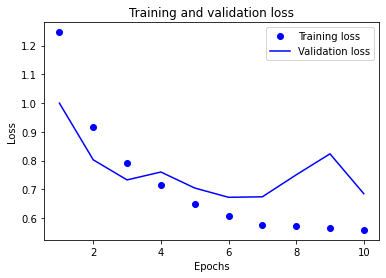

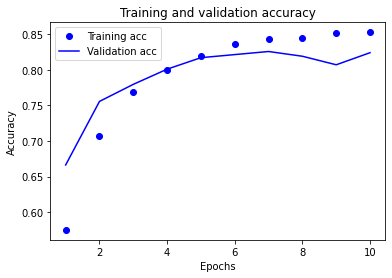

Model 2


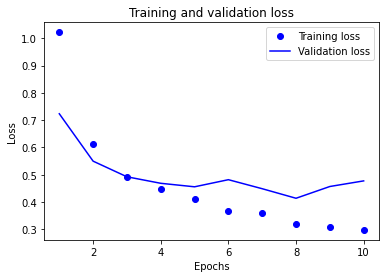

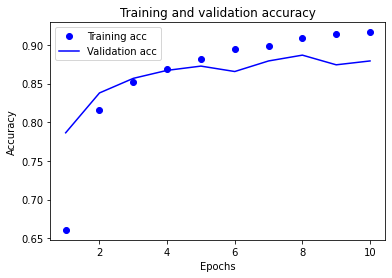

Model 3


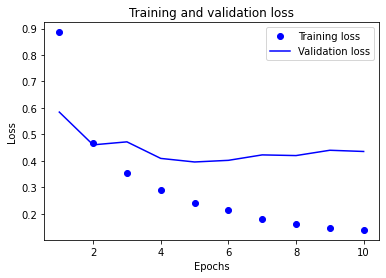

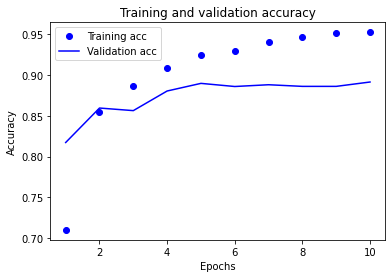

Model 4


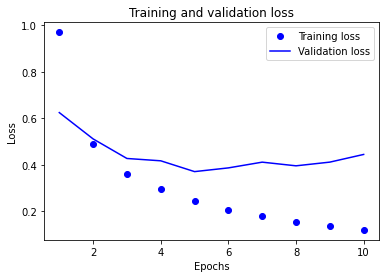

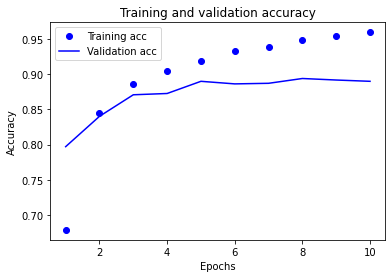

Model 5


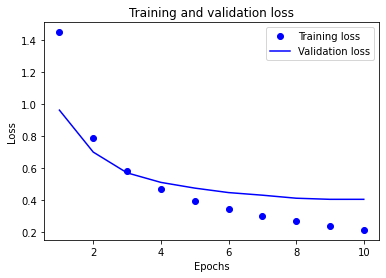

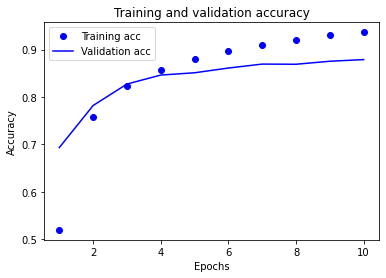

In [9]:
# init the ensemble model
ensemble_model = EnsembleModel(model_list)

# train the base models
ensemble_model.train_base_models(X_train, y_train, X_val, y_val, epochs=10)

In [11]:
# evaluate the ensemble on the validation set
print(f'Ensemble model accuracy on validation: {ensemble_model.predict_and_score(X_val, np.argmax(y_val, axis=1))}')

# evaluate the ensemble on the test set
print(f'Ensemble model accuracy on test: {ensemble_model.predict_and_score(X_test, np.argmax(y_test, axis=1))}')

Ensemble model accuracy on validation: 0.9215
Ensemble model accuracy on test: 0.7927
